# EXPLORING THE DIFFERENCES BETWEEN KNOWN FUNCTIONAL AND UNKNOWN LIGAND BINDING SITES

## IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_analysis import *

## READING INPUT DATA

In [2]:
main_dir = "/Users/2394007/Documents/PHD/LOCAL/FRAGSYS_DEF/"
results_dir = os.path.join(main_dir, "results")
all_bs_ress = pd.read_csv(os.path.join(results_dir, "all_binding_site_residues_wgroup.csv"))
all_bss = pd.read_csv(os.path.join(results_dir, "all_binding_sites.csv"))
all_bs_ress["RSA"] = all_bs_ress["RSA"].apply(lambda x: x if x <= 100 else 100)

In [3]:
func_df = load_pickle(os.path.join(results_dir, "prot_func_dict_auto_man_comb.pkl"))

In [4]:
func_df.head(3)

,bs_id,auto,manual,comb
0,H0Y4R8_0_BS0,UF,UF,UF
1,O15178_0_BS0,UF,UF,UF
2,O15178_0_BS1,UF,UF,UF


In [39]:
def f(row):
    if row['auto'] == "UF" and row['manual'] == "KF":
        val = "KF"
    else:
        val = row['auto']
    return val

In [47]:
func_df['comb'] = func_df.apply(f, axis=1)

In [5]:
func_dict = {}
for _, row in func_df.iterrows():
    prot, group, bs = row.bs_id.split("_")
    func_dict[(prot, group, bs)] = row.comb # combination of automated feature extraction and manual one

In [6]:
func_df.comb.value_counts()

UF    249
KF     44
Name: comb, dtype: int64

In [7]:
active = []
non_active = []
for k, v in func_dict.items():
    prot = k[0]
    group = k[1]
    bs_id = k[2]
    sel_rows = all_bs_ress[(all_bs_ress.protein == prot)&(all_bs_ress.group == int(group))&(all_bs_ress[bs_id] == 1)]
    if v == "KF":
        active.append(sel_rows)
    elif v == "UF":
        non_active.append(sel_rows)
active_df = pd.concat(active)
non_active_df = pd.concat(non_active)

In [32]:
active_df = pd.read_csv(os.path.join(main_dir, "results", "active_site_ress.csv"))
non_active_df = pd.read_csv(os.path.join(main_dir, "results", "non_active_site_ress.csv"))

In [8]:
print(len(active_df))
print(len(non_active_df))

5767
8456


In [9]:
active_df = active_df.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])
non_active_df = non_active_df.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])

In [10]:
print(len(active_df))
print(len(non_active_df))

691
2050


### RSA, MES, AND SHENKIN DO NOT FOLLOW A NORMAL DISTRIBUTION

In [11]:
active_df.index = range(0, len(active_df))
non_active_df.index = range(0, len(non_active_df))

In [12]:
print(scipy.stats.normaltest(active_df.log_oddsratio.tolist()))
print(scipy.stats.normaltest(non_active_df.log_oddsratio.tolist()))

NormaltestResult(statistic=27.074347971485764, pvalue=1.3209307109831062e-06)
NormaltestResult(statistic=64.17466730550996, pvalue=1.1605077781952751e-14)


In [13]:
print(scipy.stats.normaltest(active_df.shenkin.tolist()))
print(scipy.stats.normaltest(non_active_df.shenkin.tolist()))

NormaltestResult(statistic=78.14182283023712, pvalue=1.0757683664834876e-17)
NormaltestResult(statistic=215.75923969318006, pvalue=1.4075907065836751e-47)


In [14]:
print(scipy.stats.normaltest(active_df.RSA.tolist()))
print(scipy.stats.normaltest(non_active_df.RSA.tolist()))

NormaltestResult(statistic=99.0439945451912, pvalue=3.1107839652197576e-22)
NormaltestResult(statistic=161.0769102332018, pvalue=1.053400116004148e-35)


## FUNCTIONAL VS UNKNOWN: RSA

In [15]:
print(len(active_df))
print(len(non_active_df))

691
2050


691 2050


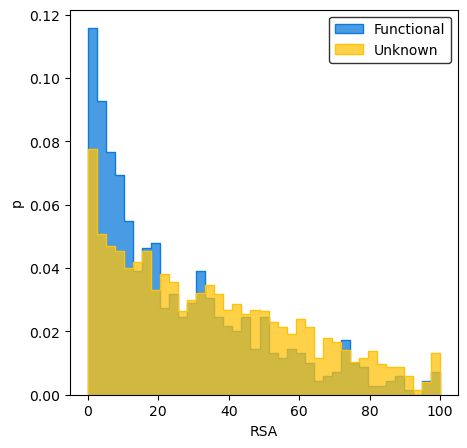

In [16]:
fig = plt.figure(figsize = (5, 5), dpi = 100)
RSA_bns = np.linspace(0, 100, 40)
a = active_df.query('RSA <= 100').RSA
b = non_active_df.query('RSA <= 100').RSA
print(len(a), len(b))
sns.histplot(a, label = "Functional", fill = True, color = "#0C7BDC", stat = "proportion", element = "step", bins = RSA_bns)
sns.histplot(b, label = "Unknown", fill = True, color = "#FFC20A", stat = "proportion", element = "step", bins = RSA_bns)
plt.ylabel("p")
plt.xlabel("RSA")
plt.legend(edgecolor = "k")
#plt.savefig(os.path.join(main_dir, "func_vs_unk_rsa.png"))
plt.show()

In [17]:
scipy.stats.anderson_ksamp([active_df.query('RSA <= 100').RSA, non_active_df.query('RSA <= 100').RSA])

/var/folders/3s/nxmgkht57nz3bb6jhzrp5fhh0000gq/T/ipykernel_9858/1911421443.py:1: UserWarning: p-value floored: true value smaller than 0.001
  scipy.stats.anderson_ksamp([active_df.query('RSA <= 100').RSA, non_active_df.query('RSA <= 100').RSA])


Anderson_ksampResult(statistic=42.72297518369387, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

In [18]:
print("RSA average (ALL residues) = ", round(statistics.mean(active_df.RSA),1))
print("RSA average (BS residues) = ", round(statistics.mean(non_active_df.RSA),1))

s, p = scipy.stats.ks_2samp(active_df.RSA, non_active_df.RSA, alternative="two-sided")
print("Kolmogorov-Smirnov two sample test result:\nKS statistic = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.mannwhitneyu(active_df.RSA, non_active_df.RSA, alternative="two-sided")
print("Mann-Whitney U rank test result:\nU = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.ttest_ind(active_df.RSA, non_active_df.RSA)
print("T-test result:\nT = {}\tp = {}".format(round(s,2), round(p,2)))

RSA average (ALL residues) =  25.4
RSA average (BS residues) =  34.1
Kolmogorov-Smirnov two sample test result:
KS statistic = 0.17	p = 0.0

Mann-Whitney U rank test result:
U = 561780.5	p = 0.0

T-test result:
T = -7.85	p = 0.0


## FUNCTIONAL VS UNKNOWN: DIVERGENCE

468 1197


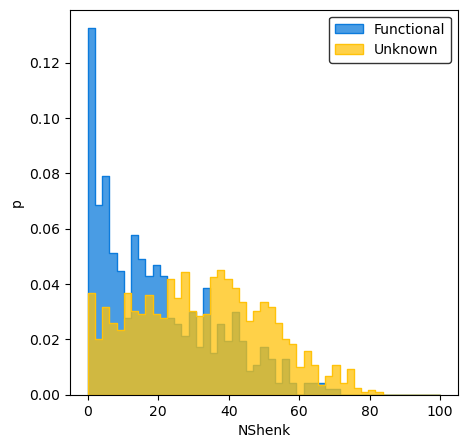

In [19]:
fig = plt.figure(figsize = (5, 5), dpi = 100)
shenk_bns = np.linspace(0, 100, 50)
a = active_df.query('occ >= 25 and occ_pct >= 0.50').abs_norm_shenkin
b = non_active_df.query('occ >= 25 and occ_pct >= 0.50').abs_norm_shenkin
print(len(a), len(b))
sns.histplot(a, label = "Functional", fill = True, color = "#0C7BDC", stat = "proportion", element = "step", bins = shenk_bns)
sns.histplot(b, label = "Unknown", fill = True, color = "#FFC20A", stat = "proportion", element = "step", bins = shenk_bns)
plt.ylabel("p")
plt.xlabel("NShenk")
plt.legend(edgecolor = "k")
#plt.savefig(os.path.join(main_dir, "func_vs_unk_shenk.png"))
plt.show()

In [20]:
scipy.stats.anderson_ksamp(
    [
        active_df.query('occ >= 25 and occ_pct >= 0.50').abs_norm_shenkin,
        non_active_df.query('occ >= 25 and occ_pct >= 0.50').abs_norm_shenkin
    ]
)

/var/folders/3s/nxmgkht57nz3bb6jhzrp5fhh0000gq/T/ipykernel_9858/623812957.py:1: UserWarning: p-value floored: true value smaller than 0.001
  scipy.stats.anderson_ksamp(


Anderson_ksampResult(statistic=104.75819493187241, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

In [21]:
print("Shenkin average (FUNCTIONAL residues) = ", round(statistics.mean(active_df.shenkin),0))
print("Shenkin average (UNKNOWN residues) = ", round(statistics.mean(non_active_df.shenkin),0))

s, p = scipy.stats.ks_2samp(active_df.abs_norm_shenkin, non_active_df.abs_norm_shenkin, alternative="two-sided")
print("Kolmogorov-Smirnov two sample test result:\nKS statistic = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.mannwhitneyu(active_df.abs_norm_shenkin, non_active_df.abs_norm_shenkin, alternative="two-sided")
print("Mann-Whitney U rank test result:\nU = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.ttest_ind(active_df.abs_norm_shenkin, non_active_df.abs_norm_shenkin)
print("T-test result:\nT = {}\tp = {}".format(round(s,2), round(p,2)))

Shenkin average (FUNCTIONAL residues) =  26.0
Shenkin average (UNKNOWN residues) =  39.0
Kolmogorov-Smirnov two sample test result:
KS statistic = 0.27	p = 0.0

Mann-Whitney U rank test result:
U = 459677.0	p = 0.0

T-test result:
T = -13.77	p = 0.0


## FUNCTIONAL VS UNKNOWN: MES

372 857


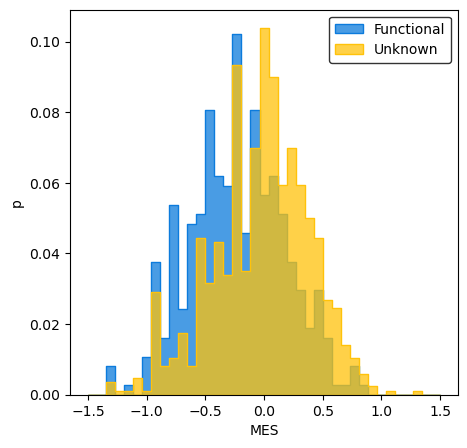

In [22]:
fig = plt.figure(figsize = (5, 5), dpi = 100)
mes_bns = np.linspace(-1.5, 1.5, 40)
a = active_df.query('occ >= 25 and occ_pct >= 0.50 & human_occ > 10 & human_occ_pct > 0.50 & variants >= 2').log_oddsratio
b = non_active_df.query('occ >= 25 and occ_pct >= 0.50 & human_occ > 10 & human_occ_pct > 0.50 & variants >= 2').log_oddsratio
print(len(a), len(b))
sns.histplot(a, label = "Functional", fill = True, color = "#0C7BDC", stat = "proportion", element = "step", bins = mes_bns)
sns.histplot(b, label = "Unknown", fill = True, color = "#FFC20A", stat = "proportion", element = "step", bins = mes_bns)
plt.ylabel("p")
plt.xlabel("MES")
plt.legend(edgecolor = "k")
#plt.savefig(os.path.join(main_dir, "func_vs_unk_MES.png"))
plt.show()

In [23]:
scipy.stats.anderson_ksamp(
    [
        active_df.query('occ >= 25 and occ_pct >= 0.50 & human_occ > 10 & human_occ_pct > 0.50 & variants >= 2').log_oddsratio,
        non_active_df.query('occ >= 25 and occ_pct >= 0.50 & human_occ > 10 & human_occ_pct > 0.50 & variants >= 2').log_oddsratio
    ]
)

/var/folders/3s/nxmgkht57nz3bb6jhzrp5fhh0000gq/T/ipykernel_9858/2120013606.py:1: UserWarning: p-value floored: true value smaller than 0.001
  scipy.stats.anderson_ksamp(


Anderson_ksampResult(statistic=45.72428785837081, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

In [24]:
print("MES average (FUNCIONAL residues) = ", round(statistics.mean(active_df.log_oddsratio),1))
print("MES average (UNKNOWN residues) = ", round(statistics.mean(non_active_df.log_oddsratio),1))

s, p = scipy.stats.ks_2samp(active_df.log_oddsratio, non_active_df.log_oddsratio, alternative="two-sided")
print("Kolmogorov-Smirnov two sample test result:\nKS statistic = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.mannwhitneyu(active_df.log_oddsratio, non_active_df.log_oddsratio, alternative="two-sided")
print("Mann-Whitney U rank test result:\nU = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.ttest_ind(active_df.log_oddsratio, non_active_df.log_oddsratio)
print("T-test result:\nT = {}\tp = {}".format(round(s,2), round(p,2)))

MES average (FUNCIONAL residues) =  -0.2
MES average (UNKNOWN residues) =  -0.0
Kolmogorov-Smirnov two sample test result:
KS statistic = 0.19	p = 0.0

Mann-Whitney U rank test result:
U = 554609.0	p = 0.0

T-test result:
T = -8.29	p = 0.0
